<a href="https://colab.research.google.com/github/oded-kapeta10/Time-Series-Forecasting-Delhi-Temperature-Dataset/blob/main/Project_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from torch.utils.data import TensorDataset, DataLoader
from prophet import Prophet
from prophet.plot import plot_components

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [ ]:
df = pd.read_csv('/content/Train_data_213064744_214096745.csv')
df.loc[df['meanpressure'] < 900, 'meanpressure'] = df['meanpressure'].mean()

rng = pd.date_range(start = '2013-01-01', end = '2017-01-01', freq='D')
df.set_index(rng, inplace=True) #change index to dates.

df_test = pd.read_csv('/content/Test_data_213064744_214096745.csv')
df_test.loc[df_test['meanpressure'] < 900, 'meanpressure'] = df_test['meanpressure'].mean()

rng_test = pd.date_range(start = '2017-01-01', end = '2017-04-24', freq='D')
df_test.set_index(rng_test, inplace=True) #change index to dates.
mean_w = df['wind_speed'].mean()
std_w = df['wind_speed'].std()



In [ ]:
# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Sort df (train data) by date
df = df.sort_values(by='date')


# Move last N days from df to df_test
N = 154
last_N_days = df.iloc[-N:]  # Select last N rows

# Remove these rows from df
df = df.iloc[:-N]

# Append to df_test and then sort by date
df_test = pd.concat([last_N_days, df_test], ignore_index=True)


df_test = df_test.sort_values(by='date').reset_index(drop=True)



In [ ]:
df2 = df.copy()
df_test2 = df_test.copy()


# **part 1 - Data Selection, Visualization, and Introduction**

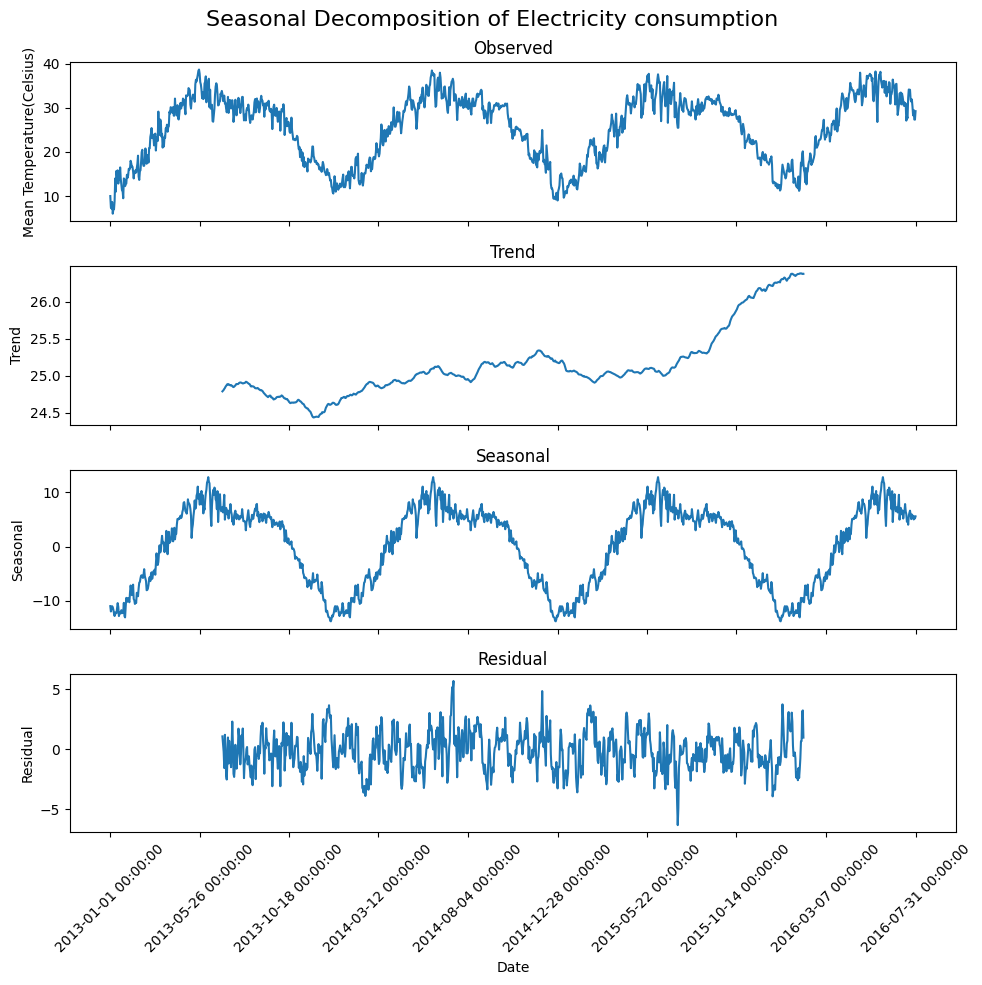

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Create the figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
SES = seasonal_decompose(df['meantemp'], period=365, model='additive')

# # Plot the data on each subplot
axs[0].plot(df.index[:], SES.observed)
axs[1].plot(df.index[:], SES.trend)
axs[2].plot(df.index[:], SES.seasonal)
axs[3].plot(df.index[:], SES.resid)

# # Add suptitle for the entire figure
fig.suptitle('Seasonal Decomposition of Electricity consumption', fontsize=16)

# Add titles and labels for each subplot
axs[0].set_title('Observed')
axs[0].set_ylabel('Mean Temperature(Celsius)')
axs[1].set_title('Trend')
axs[1].set_ylabel('Trend')
axs[2].set_title('Seasonal')
axs[2].set_ylabel('Seasonal')
axs[3].set_title('Residual')
axs[3].set_ylabel('Residual')
axs[3].set_xlabel('Date')
# Set xticks for the last subplot
xticks_indices = np.linspace(0, df.shape[0]-1, 10, dtype=int)
axs[3].set_xticks(df.index[xticks_indices])
axs[3].set_xticklabels(df.index[xticks_indices], rotation=45)
# Show the plot
plt.tight_layout()
plt.show()

Trend: It can be seen that there is trend in this graph, as there is consistent upward movement.

Seasonality: This graph shows an annual seasonality, as peaks appear at the beginning and end of each year. This result aligns with the logical expectation that temperatures would be lower in winter months and higher in summer months.

Noise: It is noticeable that there is noise in this series. The graph line is not "smooth," indicating small fluctuations over short time intervals.

# **part 2 - Model Fitting**

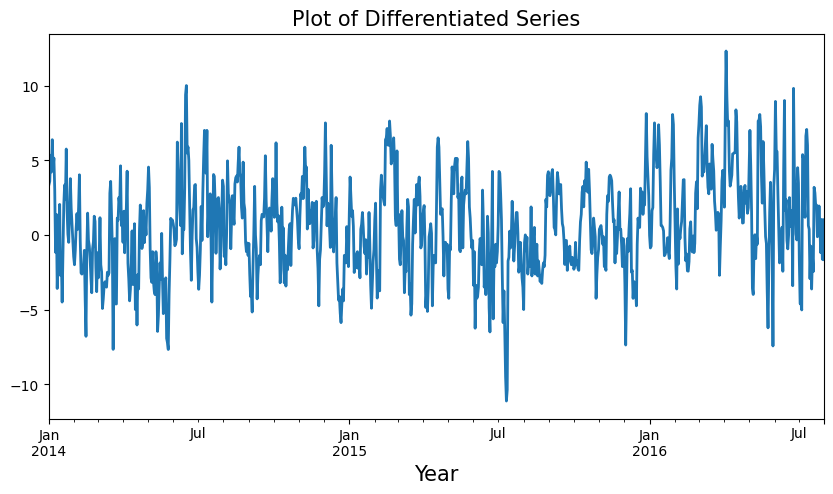

In [ ]:
#Remove seasonality using diff
df_diff= df['meantemp'].diff(periods=365)
df_diff= df_diff.dropna()


#plot series after removing seasonality
df_diff.plot(figsize=(10,5), linewidth=2, fontsize=10)
plt.title("Plot of Differentiated Series",fontsize=15)
plt.xlabel('Year', fontsize=15);



# **SARIMA model**

In [ ]:
# Aggregate temperature to weekly mean
df_weekly = df['meantemp'].resample('W').mean()
df_diff_w = df_weekly.diff(periods=52)
df_diff_w = df_diff_w.dropna()



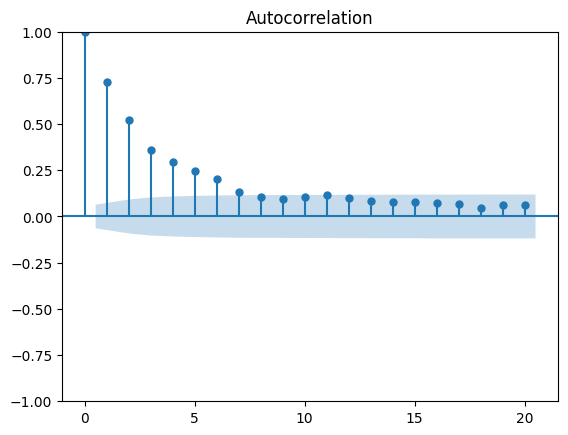

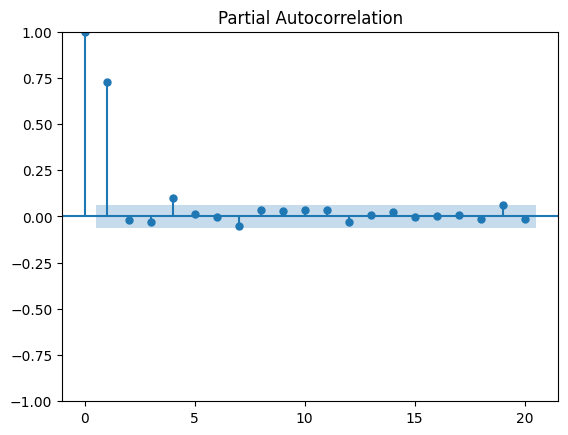

In [ ]:
#autocorrelation & partial autocorrelation
tsaplots.plot_acf(df_diff,lags=20);
tsaplots.plot_pacf(df_diff,lags=20);

In [ ]:
model_sarima = SARIMAX(df_weekly, order=(1, 1,1), seasonal_order=(1,1 ,1,52))
results = model_sarima.fit(disp=False)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
forecast_res = results.get_forecast(steps=104)
forecast_values = forecast_res.predicted_mean  # Forecasted values
confidence_intervals = forecast_res.conf_int()  # 95% confidence interval

futureDF_forecast = pd.DataFrame(forecast_values)


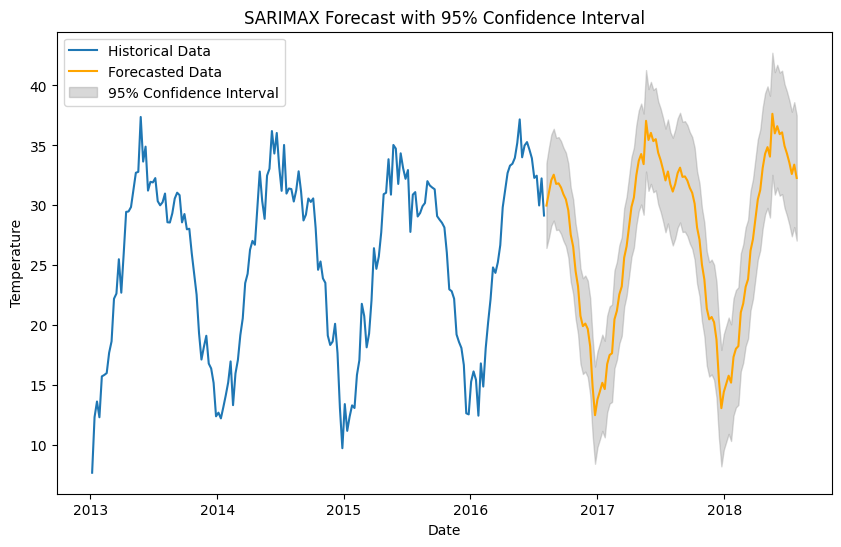

In [ ]:
# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(df_weekly, label='Historical Data')

# Plot the forecasted values
plt.plot(futureDF_forecast.index, futureDF_forecast, label='Forecasted Data', color='orange')

# Plot the confidence intervals
plt.fill_between(futureDF_forecast.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='gray', alpha=0.3, label='95% Confidence Interval')

plt.title('SARIMAX Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

# **Fourier**


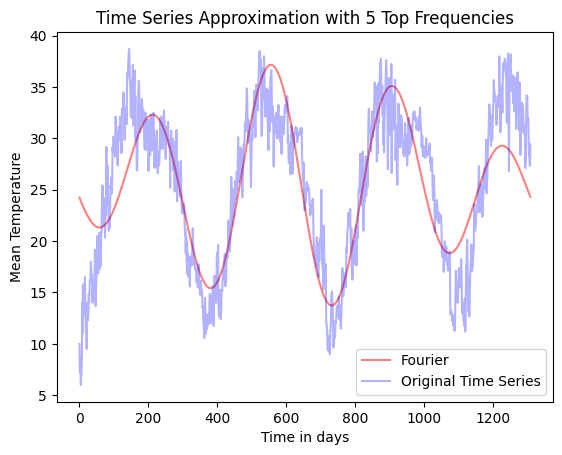

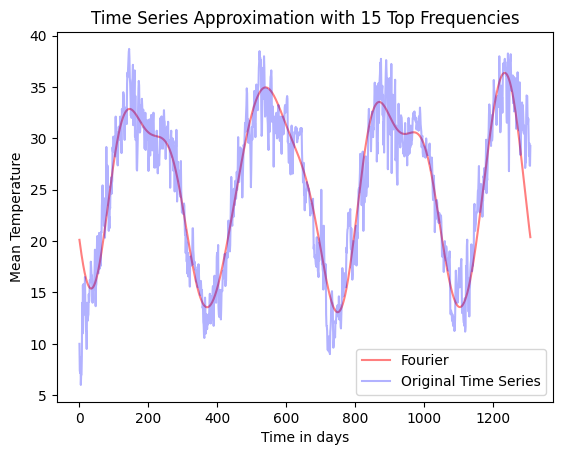

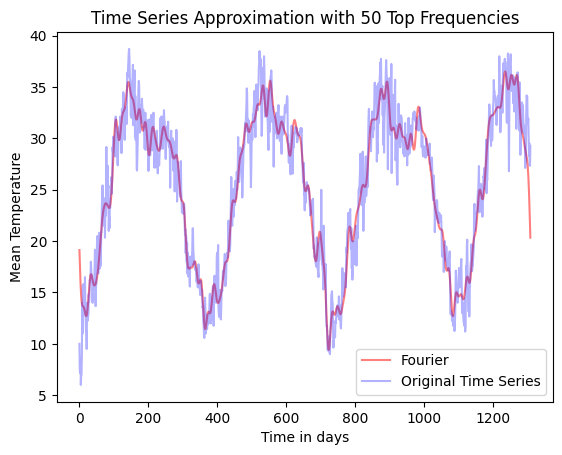

In [ ]:

time_series = df['meantemp']
# Perform Fourier Transform
fft_result = np.fft.fft(time_series)
frequencies = np.fft.fftfreq(len(time_series))
# Get magnitude and sort indices by magnitude
magnitude = np.abs(fft_result)
sorted_indices = np.argsort(magnitude)[::-1]
# Top k frequencies
for k in [5,15,50]:

  top_k_indices = sorted_indices[:k]
  # Create a filtered FFT result
  filtered_fft = np.zeros_like(fft_result, dtype=complex)
  filtered_fft[top_k_indices] = fft_result[top_k_indices]
  # Reconstruct the time series with top k frequencies
  reconstructed_series = np.fft.ifft(filtered_fft).real
  plt.plot(reconstructed_series, label='Fourier', color='red', alpha=0.5)
  plt.plot(time_series.values, label='Original Time Series', color='blue', alpha=0.3)
  plt.legend()
  plt.title(f"Time Series Approximation with {k} Top Frequencies")
  plt.xlabel('Time in days')
  plt.ylabel('Mean Temperature')
  plt.show()

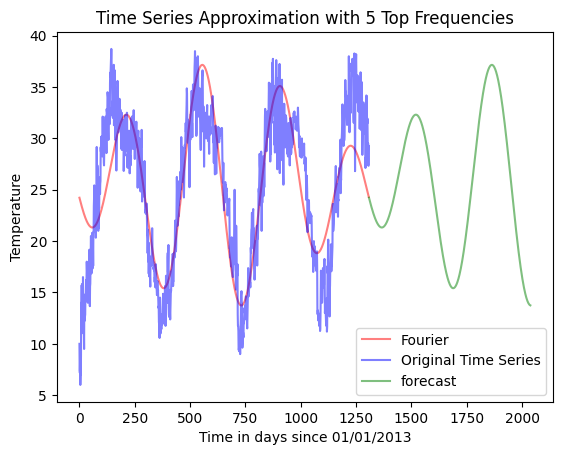

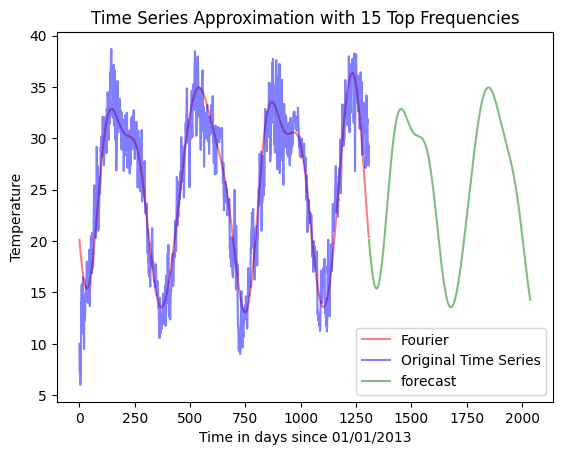

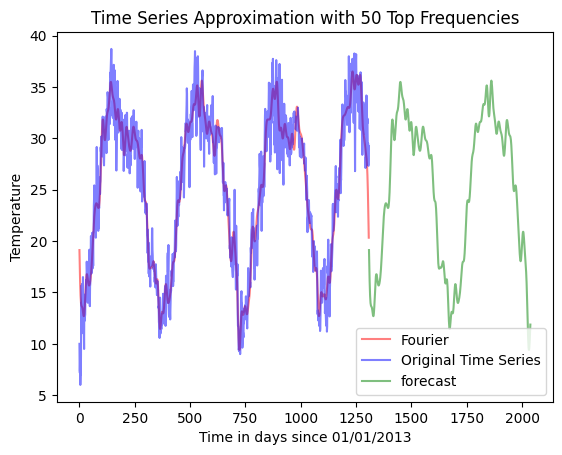

In [ ]:

#forecast
forcasted_data = {}
forecast = 730
for k in [5,15,50]:
  top_k_indices = sorted_indices[:k]
  # Create a filtered FFT result
  filtered_fft = np.zeros_like(fft_result, dtype=complex)
  filtered_fft[top_k_indices] = fft_result[top_k_indices]
  # Reconstruct the time series with top k frequencies
  reconstructed_series = np.fft.ifft(filtered_fft).real
  forcasted_data[k] = reconstructed_series[:forecast]
  plt.plot(reconstructed_series, label='Fourier', color='red', alpha=0.5)
  plt.plot(time_series.values, label='Original Time Series', color='blue', alpha=0.5)
  plt.plot(np.arange(len(time_series), len(time_series)+forecast),
  reconstructed_series[:forecast], label='forecast', color='green', alpha=0.5)
  plt.legend()
  plt.title(f"Time Series Approximation with {k} Top Frequencies")
  plt.xlabel('Time in days since 01/01/2013')
  plt.ylabel('Temperature')
  plt.show()

# **prophet**

In [ ]:
df_prophet = df.copy()
df_prophet['ds'] = df.index
df_prophet = df_prophet.rename(columns={'meantemp': 'y'})
df_prophet = df_prophet[['ds','y']]


In [ ]:
model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
model.fit(df_prophet)


DEBUG:cmdstanpy:input tempfile: /tmp/tmplh7cu_ag/9bhwrqdo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplh7cu_ag/4p1nc_fn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14451', 'data', 'file=/tmp/tmplh7cu_ag/9bhwrqdo.json', 'init=/tmp/tmplh7cu_ag/4p1nc_fn.json', 'output', 'file=/tmp/tmplh7cu_ag/prophet_model0xko3be4/prophet_model-20250402131524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:15:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:15:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=730, freq='D')
forecast = model.predict(future)



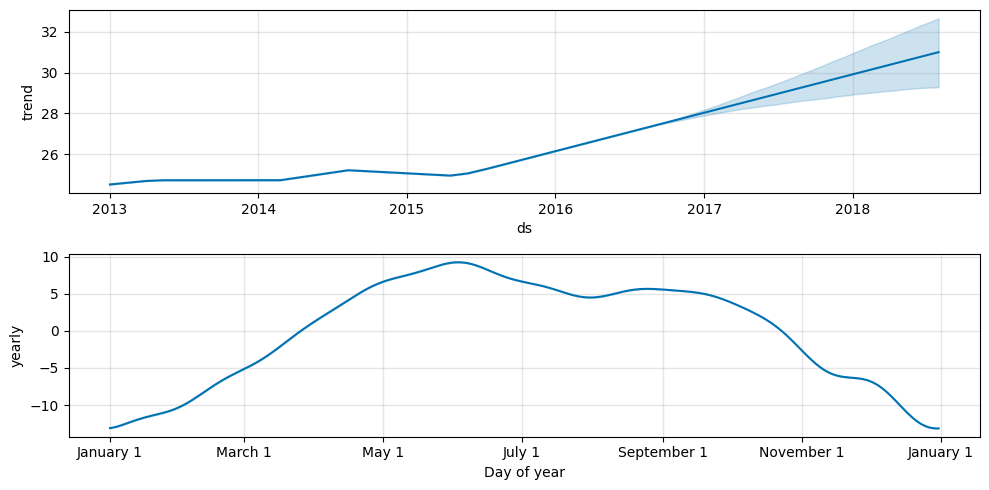

In [ ]:
fig = plot_components(model, forecast, figsize=(10,5))
fig.show()

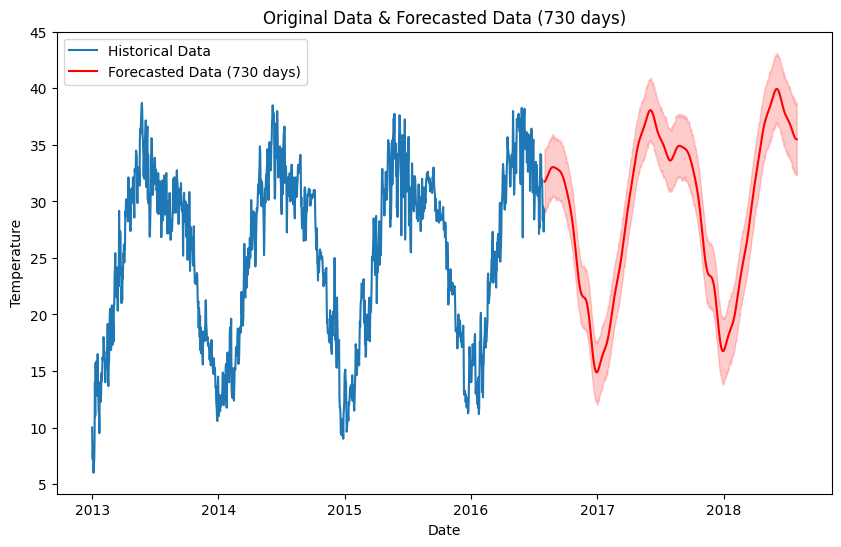

In [ ]:
last_730_forecast = forecast.tail(730)
# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(df['meantemp'], label='Historical Data')

# Plot last 730 forecasted values
plt.plot(last_730_forecast['ds'], last_730_forecast['yhat'], label='Forecasted Data (730 days)', color='red')

# plot the uncertainty intervals
plt.fill_between(last_730_forecast['ds'], last_730_forecast['yhat_lower'], last_730_forecast['yhat_upper'], color='red', alpha=0.2)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Original Data & Forecasted Data (730 days)')
plt.legend()

# Show the plot
plt.show()

# **Comparing**

In [ ]:
df_test['date'] = pd.to_datetime(df_test['date'])

# Set 'date' as the index
df_test = df_test.set_index('date')


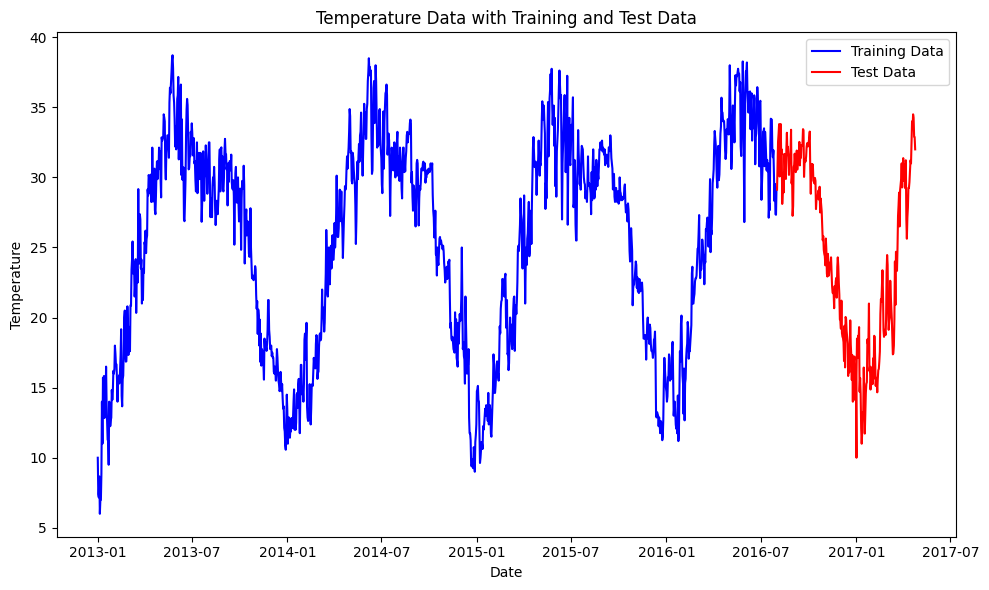

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['meantemp'], label='Training Data', color='blue')

# Plot the test data (df_test) with a different color
plt.plot(df_test.index, df_test['meantemp'], label='Test Data', color='red')

# Add titles and labels
plt.title('Temperature Data with Training and Test Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
def mse(train_data,test_data):
  train_data = np.array(train_data)
  test_data = np.array(test_data)
  mse = np.mean((train_data-test_data)**2)
  return mse

def mean_absolute_percentage_error(df_true, df_pred):
    # Ensure the inputs are numpy arrays or pandas series
    y_true, y_pred = np.array(df_true), np.array(df_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# MSE for sarima model and aggregate the test data per week

test_weekly = df_test['meantemp'].resample('W').mean()


mse_sarima = mse(futureDF_forecast[:39],test_weekly)
print(f"MSE for sarima model is {mse_sarima:.4f}")
mape_sarima = mean_absolute_percentage_error(test_weekly,futureDF_forecast[:39])
print(f"MAPE for sarima model is {mape_sarima:.4f}")
print()

means_week = {}
# MSE for fourier model
for k in [5,15,50]:
  # aggregate per week
  data = forcasted_data[k][:268]

  num_full_weeks = len(data) // 7  # Number of complete weeks
  remaining_days = len(data) % 7    # Extra days that don’t form a full week

  # Compute weekly means for full weeks
  weekly_means = data[:num_full_weeks * 7].reshape(num_full_weeks, 7).mean(axis=1)

  # Compute the mean for the remaining days
  if remaining_days > 0:
      last_week_mean = np.mean(data[num_full_weeks * 7:])  # Mean of remaining days
      weekly_means = np.append(weekly_means, last_week_mean)  # Append it to results
  means_week[k] = weekly_means
  mse_fourier = mse(weekly_means,test_weekly)
  print(f'MSE for k = {k} in fourier method is {mse_fourier:.4f}')
  mape_fourier = mean_absolute_percentage_error(weekly_means,test_weekly)
  print(f'MAPE for k = {k} in fourier method is {mape_fourier:.4f}')
  print()

# MSE for prophet model

#aggregate per week

data = last_730_forecast['yhat'][:268]
# Number of complete weeks
num_full_weeks = len(data) // 7
# Remaining days that don’t form a full week
remaining_days = len(data) % 7
# Compute weekly means for full weeks
weekly_means = data[:num_full_weeks * 7].values.reshape(num_full_weeks, 7).mean(axis=1)
# Compute the mean for the remaining days
if remaining_days > 0:
    last_week_mean = data[num_full_weeks * 7:].mean()  # Mean of remaining days
    weekly_means = np.append(weekly_means, last_week_mean)  # Append it to results
# Convert to pandas Series

weekly_means_series = pd.Series(weekly_means)
mse_prophet = mse(weekly_means,test_weekly)
print(f"MSE for prophet is {mse_prophet:.4f}")
mape_prophet = mean_absolute_percentage_error(weekly_means,test_weekly)
print(f"MAPE for prophet is {mape_prophet:.4f}")


MSE for sarima model is 81.3149
MAPE for sarima model is 32.6288

MSE for k = 5 in fourier method is 89.0312
MAPE for k = 5 in fourier method is 31.0106

MSE for k = 15 in fourier method is 139.9140
MAPE for k = 15 in fourier method is 44.2332

MSE for k = 50 in fourier method is 151.4633
MAPE for k = 50 in fourier method is 47.0434

MSE for prophet is 3.4400
MAPE for prophet is 6.0304


# **part 3 - exogenous variables**

In [ ]:



class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Taking the output from the last time step
        return out


In [ ]:
df2['date'] = pd.to_datetime(df2['date'])
df_test2['date'] = pd.to_datetime(df_test2['date'])
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day
df_test2['year'] = df_test2['date'].dt.year
df_test2['month'] = df_test2['date'].dt.month
df_test2['day'] = df_test2['date'].dt.day


In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(df2.drop(['date', 'meantemp'], axis=1).values)
X_test_scaled = scaler_X.transform(df_test2.drop(['date', 'meantemp'], axis=1).values)

# Converting to torch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

# Normalizing the target (y_train and y_test)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(df['meantemp'].values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(df_test['meantemp'].values.reshape(-1, 1))

# Converting target to torch tensors
y_train = torch.tensor(y_train_scaled.squeeze(), dtype=torch.float32)
y_test = torch.tensor(y_test_scaled.squeeze(), dtype=torch.float32)

# Creating datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Creating DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No shuffle for LSTM
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
input_size = X_train.shape[1]
hidden_size = 500
output_size = 1
num_epochs = 20
learning_rate = 0.0005
X_train = X_train.unsqueeze(1)  # Adds a sequence length of 1
X_test = X_test.unsqueeze(1)


In [ ]:
# Initialize model, loss function, and optimizer
import torch
import torch.nn as nn
import torch.optim as optim
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
sum(p.numel() for p in model.parameters() if p.requires_grad)

7028501

In [ ]:
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()  # Reset gradients
        batch_X = batch_X.unsqueeze(1)  # Add sequence length dimension
        outputs = model(batch_X)  # Forward pass
        loss = criterion(outputs.squeeze(), batch_y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    # Print average loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")


  5%|▌         | 1/20 [00:05<01:49,  5.74s/it]

Epoch 1/20, Loss: 1.0176


 10%|█         | 2/20 [00:11<01:46,  5.91s/it]

Epoch 2/20, Loss: 0.8308


 15%|█▌        | 3/20 [00:16<01:33,  5.52s/it]

Epoch 3/20, Loss: 0.6305


 20%|██        | 4/20 [00:22<01:30,  5.68s/it]

Epoch 4/20, Loss: 0.5449


 25%|██▌       | 5/20 [00:27<01:21,  5.46s/it]

Epoch 5/20, Loss: 0.4684


 30%|███       | 6/20 [00:33<01:16,  5.46s/it]

Epoch 6/20, Loss: 0.4243


 35%|███▌      | 7/20 [00:38<01:11,  5.51s/it]

Epoch 7/20, Loss: 0.3174


 40%|████      | 8/20 [00:44<01:04,  5.39s/it]

Epoch 8/20, Loss: 0.3189


 45%|████▌     | 9/20 [00:50<01:01,  5.57s/it]

Epoch 9/20, Loss: 0.2216


 50%|█████     | 10/20 [00:55<00:54,  5.44s/it]

Epoch 10/20, Loss: 0.1253


 55%|█████▌    | 11/20 [01:01<00:52,  5.87s/it]

Epoch 11/20, Loss: 0.3096


 60%|██████    | 12/20 [01:07<00:45,  5.64s/it]

Epoch 12/20, Loss: 0.1787


 65%|██████▌   | 13/20 [01:13<00:40,  5.77s/it]

Epoch 13/20, Loss: 0.1603


 70%|███████   | 14/20 [01:18<00:33,  5.57s/it]

Epoch 14/20, Loss: 0.1109


 75%|███████▌  | 15/20 [01:23<00:27,  5.54s/it]

Epoch 15/20, Loss: 0.1216


 80%|████████  | 16/20 [01:29<00:22,  5.56s/it]

Epoch 16/20, Loss: 0.1364


 85%|████████▌ | 17/20 [01:34<00:16,  5.42s/it]

Epoch 17/20, Loss: 0.1968


 90%|█████████ | 18/20 [01:40<00:11,  5.60s/it]

Epoch 18/20, Loss: 0.0875


 95%|█████████▌| 19/20 [01:45<00:05,  5.47s/it]

Epoch 19/20, Loss: 0.0926


100%|██████████| 20/20 [01:51<00:00,  5.58s/it]

Epoch 20/20, Loss: 0.0806


In [ ]:
model.eval()
with torch.no_grad():  # Disable gradient calculation for inference
    y_pred_tensor = model(X_test)  # Get predictions
    test_loss = criterion(y_pred_tensor.squeeze(), y_test)  # Compute test loss
    print(f'Test MSELoss: {test_loss.item():.4f}')

Test MSELoss: 0.2203


In [ ]:
y_pred_unscaled = scaler_y.inverse_transform(y_pred_tensor.detach().cpu().numpy().reshape(-1, 1))


In [ ]:


data = y_pred_unscaled.squeeze()

# Ensure data is a NumPy array
data = np.asarray(data)

# Number of complete weeks
num_full_weeks = len(data) // 7
# Remaining days that don’t form a full week
remaining_days = len(data) % 7

# Compute weekly means for full weeks
weekly_means = data[:num_full_weeks * 7].reshape(num_full_weeks, 7).mean(axis=1)

# Compute the mean for the remaining days
if remaining_days > 0:
    last_week_mean = data[num_full_weeks * 7:].mean()  # Mean of remaining days
    weekly_means = np.append(weekly_means, last_week_mean)  # Append it to results

# Convert to pandas Series
weekly_means_series = pd.Series(weekly_means)

# Compute Mean Squared Error
mse_LSTM = mse(weekly_means_series, test_weekly)
print(f'mse_LSTM : {mse_LSTM:.4f}')


mse_LSTM : 8.6729


In [ ]:
model.eval()
with torch.no_grad():  # Disable gradient calculation for inference
    y_pred_train_tensor = model(X_train)  # Get predictions
    train_loss = criterion(y_pred_train_tensor.squeeze(), y_train)  # Compute test loss
    print(f'train MSELoss: {train_loss.item():.4f}')

train MSELoss: 0.0908


In [ ]:
y_pred_train_unscaled = scaler_y.inverse_transform(y_pred_train_tensor.detach().cpu().numpy().reshape(-1, 1))

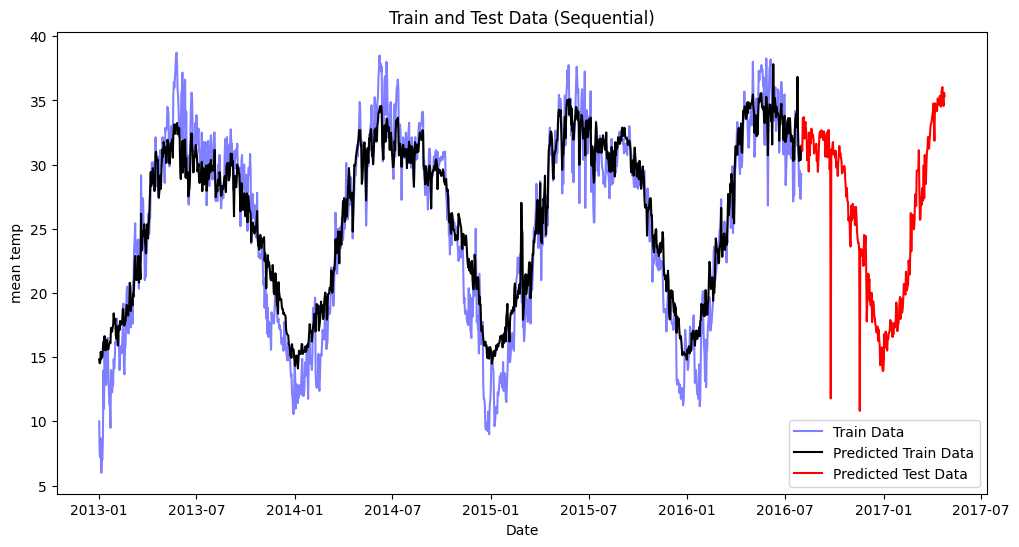

In [ ]:
plt.figure(figsize=(12, 6))
# Plot train data
plt.plot(df['date'], df['meantemp'], color='blue', label='Train Data',alpha= 0.5)

# Plot test data
plt.plot(df['date'], y_pred_train_unscaled, color='black', label='Predicted Train Data')

plt.plot(df_test2['date'],y_pred_unscaled, color='red', label='Predicted Test Data')
# plt.plot(df_test['date'], df_test['meantemp'], color='red', label='Test Data'

pos = np.arange(len(df['date']))

# ticks = plt.xticks(pos[::365], df['date'].values[::365], rotation=45)

plt.xlabel('Date')
plt.ylabel('mean temp')
plt.title('Train and Test Data (Sequential)')
plt.legend()
plt.show()


It can be seen that for the LSTM model with all external values, the prediction preserves seasonality and appears similar to the training sample, but there are some peaks resulting from outlier values.

**Training the model only with date as exogenous variable**

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
#'meantemp','meanpressure','wind_speed'
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(df2.drop(['date','meantemp','humidity','meanpressure','wind_speed'], axis=1).values)
X_test_scaled = scaler_X.transform(df_test2.drop(['date','meantemp','humidity','meanpressure','wind_speed'], axis=1).values)

# Converting to torch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

# Normalizing the target (y_train and y_test)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(df['meantemp'].values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(df_test['meantemp'].values.reshape(-1, 1))

# Converting target to torch tensors
y_train = torch.tensor(y_train_scaled.squeeze(), dtype=torch.float32)
y_test = torch.tensor(y_test_scaled.squeeze(), dtype=torch.float32)

# Creating datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Creating DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No shuffle for LSTM
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
input_size = X_train.shape[1]
hidden_size = 500
output_size = 1
num_epochs = 20
learning_rate = 0.0005
X_train = X_train.unsqueeze(1)  # Adds a sequence length of 1
X_test = X_test.unsqueeze(1)


In [ ]:
# Initialize model, loss function, and optimizer
import torch
import torch.nn as nn
import torch.optim as optim
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
sum(p.numel() for p in model.parameters() if p.requires_grad)

7022501

In [ ]:
model2 = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model2.parameters(), lr=0.001)  # Adam optimizer

# Training loop

for epoch in tqdm(range(num_epochs)):
    model2.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()  # Reset gradients
        batch_X = batch_X.unsqueeze(1)  # Add sequence length dimension
        outputs = model2(batch_X)  # Forward pass
        loss = criterion(outputs.squeeze(), batch_y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    # Print average loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")


  5%|▌         | 1/20 [00:05<01:40,  5.31s/it]

Epoch 1/20, Loss: 1.0191


 10%|█         | 2/20 [00:11<01:44,  5.78s/it]

Epoch 2/20, Loss: 1.0043


 15%|█▌        | 3/20 [00:16<01:34,  5.53s/it]

Epoch 3/20, Loss: 1.0034


 20%|██        | 4/20 [00:22<01:29,  5.62s/it]

Epoch 4/20, Loss: 1.0021


 25%|██▌       | 5/20 [00:28<01:28,  5.89s/it]

Epoch 5/20, Loss: 0.9550


 30%|███       | 6/20 [00:34<01:20,  5.74s/it]

Epoch 6/20, Loss: 0.9959


 35%|███▌      | 7/20 [00:40<01:14,  5.75s/it]

Epoch 7/20, Loss: 0.8639


 40%|████      | 8/20 [00:45<01:06,  5.56s/it]

Epoch 8/20, Loss: 0.9849


 45%|████▌     | 9/20 [00:51<01:02,  5.70s/it]

Epoch 9/20, Loss: 0.9852


 50%|█████     | 10/20 [00:56<00:56,  5.68s/it]

Epoch 10/20, Loss: 0.9091


 55%|█████▌    | 11/20 [01:02<00:52,  5.80s/it]

Epoch 11/20, Loss: 0.5956


 60%|██████    | 12/20 [01:08<00:44,  5.61s/it]

Epoch 12/20, Loss: 0.4287


 65%|██████▌   | 13/20 [01:14<00:40,  5.74s/it]

Epoch 13/20, Loss: 0.5492


 70%|███████   | 14/20 [01:19<00:33,  5.57s/it]

Epoch 14/20, Loss: 0.3295


 75%|███████▌  | 15/20 [01:24<00:27,  5.54s/it]

Epoch 15/20, Loss: 0.5056


 80%|████████  | 16/20 [01:30<00:22,  5.60s/it]

Epoch 16/20, Loss: 0.1423


 85%|████████▌ | 17/20 [01:35<00:16,  5.47s/it]

Epoch 17/20, Loss: 0.3292


 90%|█████████ | 18/20 [01:41<00:11,  5.63s/it]

Epoch 18/20, Loss: 0.1816


 95%|█████████▌| 19/20 [01:46<00:05,  5.48s/it]

Epoch 19/20, Loss: 0.2381


100%|██████████| 20/20 [01:52<00:00,  5.64s/it]

Epoch 20/20, Loss: 0.1655


In [ ]:
model2.eval()
with torch.no_grad():  # Disable gradient calculation for inference
    y_pred_tensor = model2(X_test)  # Get predictions
    test_loss = criterion(y_pred_tensor.squeeze(), y_test)  # Compute test loss
    print(f'Test MSELoss: {test_loss.item():.4f}')

Test MSELoss: 0.1623


In [ ]:
y_pred_unscaled = scaler_y.inverse_transform(y_pred_tensor.detach().cpu().numpy().reshape(-1, 1))


In [ ]:


data = y_pred_unscaled.squeeze()

# Ensure data is a NumPy array
data = np.asarray(data)

# Number of complete weeks
num_full_weeks = len(data) // 7
# Remaining days that don’t form a full week
remaining_days = len(data) % 7

# Compute weekly means for full weeks
weekly_means = data[:num_full_weeks * 7].reshape(num_full_weeks, 7).mean(axis=1)

# Compute the mean for the remaining days
if remaining_days > 0:
    last_week_mean = data[num_full_weeks * 7:].mean()  # Mean of remaining days
    weekly_means = np.append(weekly_means, last_week_mean)  # Append it to results

# Convert to pandas Series
weekly_means_series = pd.Series(weekly_means)

# Compute Mean Squared Error
mse_LSTM = mse(weekly_means_series, test_weekly)
print(f'mse_LSTM : {mse_LSTM:.4f}')


mse_LSTM : 6.4943


In [ ]:
model2.eval()
with torch.no_grad():  # Disable gradient calculation for inference
    y_pred_train_tensor = model2(X_train)  # Get predictions
    train_loss = criterion(y_pred_train_tensor.squeeze(), y_train)  # Compute test loss
    print(f'train MSELoss: {train_loss.item():.4f}')

train MSELoss: 0.1089


In [ ]:
y_pred_train_unscaled = scaler_y.inverse_transform(y_pred_train_tensor.detach().cpu().numpy().reshape(-1, 1))

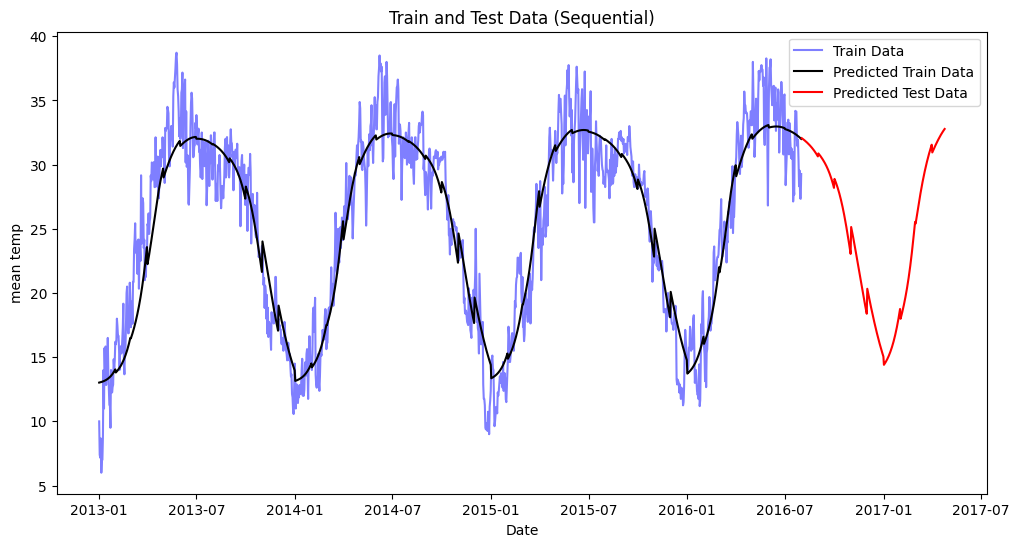

In [ ]:
plt.figure(figsize=(12, 6))
# Plot train data
plt.plot(df['date'], df['meantemp'], color='blue', label='Train Data',alpha= 0.5)

# Plot test data
plt.plot(df['date'], y_pred_train_unscaled, color='black', label='Predicted Train Data')

plt.plot(df_test2['date'],y_pred_unscaled, color='red', label='Predicted Test Data')
# plt.plot(df_test['date'], df_test['meantemp'], color='red', label='Test Data'

pos = np.arange(len(df['date']))

# ticks = plt.xticks(pos[::365], df['date'].values[::365], rotation=45)

plt.xlabel('Date')
plt.ylabel('mean temp')
plt.title('Train and Test Data (Sequential)')
plt.legend()
plt.show()


It can be seen that for the LSTM model, when the only external variable is the date, the prediction preserves seasonality, and additionally, the prediction line is smoother and less noisy.

# **part 4 - change point detection**

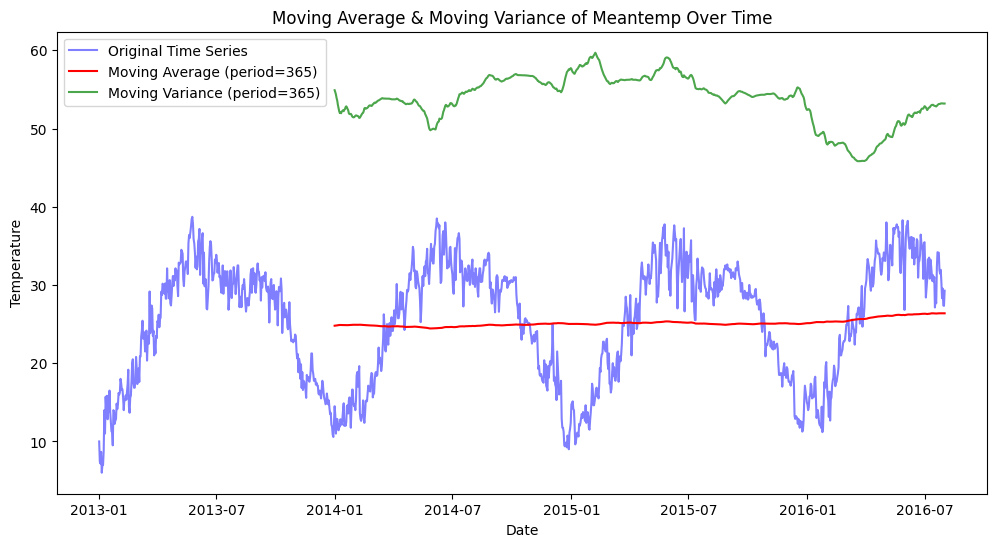

In [ ]:
#plot the moving average and moving variance over time

df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values(by='date')

# Set the rolling window size
window_size = 365

# Compute moving average and variance
df['moving_avg'] = df['meantemp'].rolling(window=window_size).mean()
df['moving_var'] = df['meantemp'].rolling(window=window_size).var()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['meantemp'], label="Original Time Series", alpha=0.5, color="blue")
plt.plot(df['date'], df['moving_avg'], label=f"Moving Average (period={window_size})", color="red")
plt.plot(df['date'], df['moving_var'], label=f"Moving Variance (period={window_size})", color="green", alpha=0.7)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Moving Average & Moving Variance of Meantemp Over Time")
plt.show()

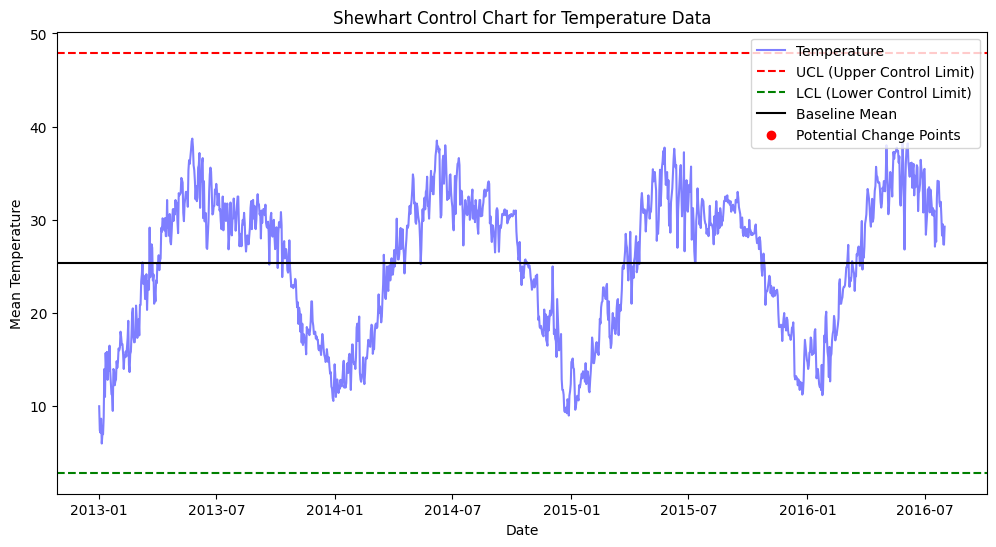

In [ ]:
# using The Shewhart Control Chart

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')  # Sort by date

# Define baseline period
baseline_period = df[df['date'] < '2017-01-01']

# Compute mean and standard deviation for baseline
baseline_mean = baseline_period['meantemp'].mean()
baseline_std = baseline_period['meantemp'].std()

# Set control limits (UCL and LCL using 3 sigma rule,99.7% confidence)
k = 3
UCL = baseline_mean + k * baseline_std
LCL = baseline_mean - k * baseline_std

# Identify points exceeding control limits
df['outlier'] = (df['meantemp'] > UCL) | (df['meantemp'] < LCL)

# Plot the Shewhart Control Chart
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['meantemp'], label='Temperature', color='blue', alpha=0.5)
plt.axhline(UCL, color='red', linestyle='--', label='UCL (Upper Control Limit)')
plt.axhline(LCL, color='green', linestyle='--', label='LCL (Lower Control Limit)')
plt.axhline(baseline_mean, color='black', linestyle='-', label='Baseline Mean')

plt.scatter(df[df['outlier']]['date'], df[df['outlier']]['meantemp'], color='red', label='Potential Change Points')

plt.legend()
plt.title("Shewhart Control Chart for Temperature Data")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()